# Time / precision

In [1]:
# sélection du cas test
testcase = 1
version = 1
param_num = 1

**Idée :** On se place ici dans un des cas tests proposés.

On cherche à vérifier les convergences obtenues pour

- FEM standard
- le PINNs + Correction par addition

On choisira d'effectuer ces convergences en P1,P2 et P3

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
import time
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.despine(left=True)
import dataframe_image as dfi

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from modules.solver_fem import FEMSolver
from modules.utils import create_tree

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/u2/lecourtier/miniconda3/envs/test_phifem/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Using device: cpu


<Figure size 640x480 with 0 Axes>

In [4]:
if testcase == 1:
    if version == 1:
        from modules.testcases.test_1 import Run_laplacian2D,Poisson_2D
    elif version == 2:
        from modules.testcases.test_1_v2 import Run_laplacian2D,Poisson_2D
    else:
        raise ValueError("Version not found")
    from modules.problem import TestCase1
    problem = TestCase1()
elif testcase == 2:
    from modules.testcases.test_2 import Run_laplacian2D,Poisson_2D
    from modules.problem import TestCase2
    problem = TestCase2()
else:
    raise ValueError("Testcase not found")

result_dir = "../results/testcase"+str(testcase)
if version != 1:
    result_dir += "_v"+str(version)
result_dir += "/time_precision/"
create_tree(result_dir)

torch loaded; device is cpu


/home/u2/lecourtier/Article1
>> load network /home/u2/lecourtier/Article1/networks/test_fe1.pth
jsbdbshd
network loaded


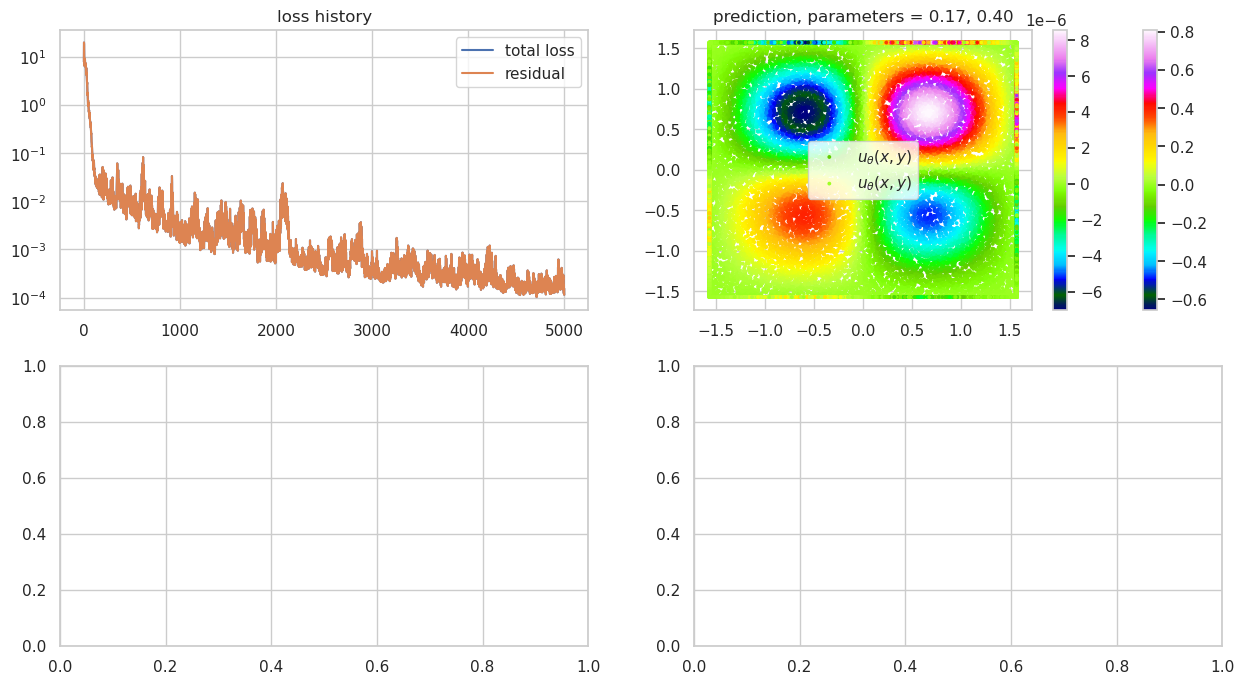

In [5]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [6]:
def get_param(i):
    params = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = [np.random.uniform(params[0][0], params[0][1]), np.random.uniform(params[1][0], params[1][1])]
    param = np.round(param, 2)
    return param

param = get_param(param_num)
params = [param]

## Convergence FEM

In [7]:
def read_csv(testcase,param_num,degree):
    df_FEM = pd.read_csv(result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_FEM = list(df_FEM['nb_vert'].values)
    tab_h_FEM = list(df_FEM['h'].values)
    tab_err_FEM = list(df_FEM['err'].values)
    tab_times_FEM = list(df_FEM['times'].values)
    tab_subtimes_FEM = {}
    for key in df_FEM.keys():
        if key not in ['nb_vert', 'h', 'err', 'times']:
            tab_subtimes_FEM[key] = list(df_FEM[key].values)
    
    return df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM = read_csv(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_FEM = [2**i for i in range(3,8)]+[150]
        tab_h_FEM = []
        tab_err_FEM = []
        tab_times_FEM = []
        tab_subtimes_FEM = {}

        for nb_vert in tab_nb_vert_FEM:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_FEM.append(solver.h)
            _,norme_L2 = solver.fem(0)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_FEM.append(norme_L2)
            times_FEM = solver.times_fem
            for key in times_FEM:
                if key in tab_subtimes_FEM:
                    tab_subtimes_FEM[key].append(times_FEM[key])
                else:
                    tab_subtimes_FEM[key] = [times_FEM[key]]
            tab_times_FEM.append(sum(times_FEM.values()))
        
        df_FEM = pd.DataFrame({'nb_vert': tab_nb_vert_FEM, 'h': tab_h_FEM, 'err': tab_err_FEM, 'times': tab_times_FEM, **tab_subtimes_FEM})
        df_FEM.to_csv(csv_file, index=False)
            
    return df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM

In [8]:
degree = 1
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM = run_FEM(degree)

Read csv file ../results/testcase1/time_precision/FEM_case1_param1_degree1.csv


In [9]:
df_FEM

,nb_vert,h,err,times,mesh,assemble,solve
0,8,0.634698,0.237177,0.156457,0.000356,0.155328,0.000773
1,16,0.296192,0.059473,0.700543,0.000042,0.697872,0.002629
2,32,0.143319,0.014376,2.986231,0.000112,2.967657,0.018463
3,64,0.070522,0.003507,12.358948,0.000326,12.282283,0.076339
4,128,0.034983,0.000865,49.696384,0.001366,49.400735,0.294283
5,150,0.029818,0.000628,68.307658,0.001873,67.913296,0.392489


## Convergence PINNs+Corr

In [10]:
def get_test_sample(i,solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return V_test,X_test,mu_test

In [11]:
degree_PINNs = 10

def read_csv_Corr(testcase,param_num,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_Corr = list(df_Corr['nb_vert'].values)
    tab_h_Corr = list(df_Corr['h'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    tab_times_Corr = list(df_Corr['times'].values)
    tab_subtimes_Corr = {}
    for key in df_Corr.keys():
        if key not in ['nb_vert', 'h', 'err', 'times']:
            tab_subtimes_Corr[key] = list(df_Corr[key].values)
    
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr

def run_Corr(degree,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr = read_csv_Corr(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_Corr = [5*i for i in range(2,7)]
        tab_h_Corr = []
        tab_err_Corr = []
        tab_times_Corr = []
        tab_subtimes_Corr = {}

        for nb_vert in tab_nb_vert_Corr:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree,high_degree=degree_PINNs)
            tab_h_Corr.append(solver.h)
            
            start = time.time()
            V_test,X_test,mu_test = get_test_sample(0,solver,trainer,degree_PINNs)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild = pred["w"][:,0].cpu().detach().numpy()
            
            u_PINNs = df.Function(V_test)
            u_PINNs.vector()[:] = phi_tild.copy()
            end = time.time()
            
            time_get_u_PINNs = end - start
            
            _,_,norme_L2 = solver.corr_add(0,u_PINNs)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Corr.append(norme_L2)
            times_Corr = solver.times_corr_add
            times_Corr["get_u_PINNs"] = time_get_u_PINNs
            for key in times_Corr:
                if key in tab_subtimes_Corr:
                    tab_subtimes_Corr[key].append(times_Corr[key])
                else:
                    tab_subtimes_Corr[key] = [times_Corr[key]]
            tab_times_Corr.append(sum(times_Corr.values()))
            
            
        df_Corr = pd.DataFrame({'nb_vert': tab_nb_vert_Corr, 'h': tab_h_Corr, 'err': tab_err_Corr, 'times': tab_times_Corr, **tab_subtimes_Corr})
        df_Corr.to_csv(csv_file, index=False)
            
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr

In [12]:
degree = 1
df_Corr, tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr = run_Corr(degree)

Read csv file ../results/testcase1/time_precision/Corr_case1_param1_degree1.csv


In [13]:
df_Corr

,nb_vert,h,err,times,mesh,assemble,solve,get_u_PINNs
0,10,0.493654,0.000568,0.388964,0.000078,0.357501,0.000444,0.030942
1,15,0.317349,0.000260,0.786602,0.000047,0.724832,0.002429,0.059294
2,20,0.233836,0.000146,1.352456,0.000063,1.238351,0.005693,0.108349
3,25,0.185120,0.000093,2.060050,0.000082,1.899571,0.011126,0.149271
4,30,0.153203,0.000065,2.945869,0.000102,2.722040,0.015063,0.208664


## Plots

In [14]:
tab_times_FEM = tab_times_FEM[:-1]
tab_err_FEM = tab_err_FEM[:-1]
tab_nb_vert_FEM = tab_nb_vert_FEM[:-1]

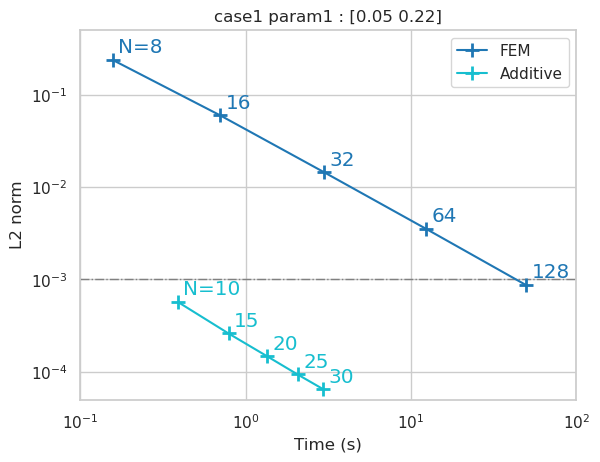

In [29]:
colors = ["tab:blue","tab:red","tab:cyan","tab:orange"]

plt.figure()

def plot_values(times,norms,color,label,tab_nb_vert):
    tab_nb_vert_str = [f"{nb_vert}" for nb_vert in tab_nb_vert]
    tab_nb_vert_str[0] = "N="+tab_nb_vert_str[0]
    plt.loglog(times,norms,"+-",color=color,label=label,markersize=10,markeredgewidth=2)
    for i in range(len(tab_nb_vert)):
        offset_x = 0.08
        offset_y = 0.08
        plt.text(times[i] * (1 + offset_x),norms[i] * (1 + offset_y),tab_nb_vert_str[i],c = color, fontsize="large",ha="left",va="bottom")
plt.axhline(y=1e-3,c="grey",linewidth=1,linestyle="-.")

plot_values(tab_times_FEM,tab_err_FEM,colors[0],"FEM",tab_nb_vert_FEM)
# plot_values(times_phifem,norms_phifem,colors[1],"PHIFEM")

plot_values(tab_times_Corr,tab_err_Corr,colors[2],"Additive",tab_nb_vert_Corr)
# plot_values(times_corr_add_phifem,norms_corr_add_phifem,colors[3],"Corr_add_PHIFEM")


plt.xlabel("Time (s)")
plt.ylabel("L2 norm")

plt.ylim(0.5e-4,5e-1)
plt.xlim(1e-1,1e2)

plt.legend()
plt.title(f'case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f"time_precision_param{param_num}_degree{degree}.png",dpi=500)

## Tableau

In [30]:
tab_subtimes_FEM["get_u_PINNs"] = None
table_methods = ["FEM","Add"]
table_steps = ["mesh","get_u_PINNs","assemble","solve","TOTAL"]

table_N = {"FEM":tab_nb_vert_FEM,"Add":tab_nb_vert_Corr}
table_norms = {"FEM":tab_err_FEM,"Add":tab_err_Corr}
table_subtimes = {"FEM":tab_subtimes_FEM,"Add":tab_subtimes_Corr}
table_times = {"FEM":tab_times_FEM,"Add":tab_times_Corr}

for method in table_methods:
    table_subtimes[method]["TOTAL"] = table_times[method]

In [31]:
###
# Interpolation
###

def get_index(norms,given_precision):
    norms = np.array(norms)
    if given_precision < norms[-1]:
        # print("droite")
        index = len(norms)-1
    elif given_precision > norms[0]:
        # print("gauche")
        index = 1
    else:           
        # print("milieu")
        index = np.where(norms < given_precision)[0][0]
    
    return index

def linear_interpolation_x(tab_x,tab_y,index,given_y):
    tab_x = np.log(np.array(tab_x))
    x = tab_x[index-1:index+1]
    tab_y = np.log(np.array(tab_y))
    y = tab_y[index-1:index+1]
    given_y = np.log(given_y)
    
    pente = (y[1]-y[0])/(x[1]-x[0])
    x_inter = x[0]+(given_y-y[0])/pente
    
    return np.exp(x_inter)

def linear_interpolation_y(tab_x,tab_y,index,given_x):
    tab_x = np.log(np.array(tab_x))
    x = tab_x[index-1:index+1]
    tab_y = np.log(np.array(tab_y))
    y = tab_y[index-1:index+1]
    given_x = np.log(given_x)

    pente = (y[1]-y[0])/(x[1]-x[0])
    y_inter = y[0]+(given_x-x[0])*pente
    
    return np.exp(y_inter)

def get_values(given_precision):
    val_inter = {}
    for method in table_methods:
        key = "TOTAL"
        
        index = get_index(table_norms[method],given_precision)
        print(table_subtimes[method][key],table_norms[method])
        t_inter = linear_interpolation_x(table_subtimes[method][key],table_norms[method],index,given_precision)
        N_inter = linear_interpolation_y(table_subtimes[method][key],table_N[method],index,t_inter)
        val_inter[method] = [N_inter,t_inter]
        
    return val_inter

In [35]:
given_precision = 1e-4
# given_precision = (table_norms["FEM"][0]+table_norms["FEM"][1])/2.0
val_inter = get_values(given_precision)
pt_FEM = [val_inter["FEM"][1],given_precision]
pt_Add = [val_inter["Add"][1],given_precision]

# Create a dataframe with the times interpolated
df_given_precision = pd.DataFrame(val_inter,columns=table_methods,index=["N","time (s)"])
df_given_precision

[0.1564571857452392, 0.7005429267883301, 2.9862313270568848, 12.35894775390625, 49.69638395309448] [0.237177480360394, 0.0594733176260162, 0.0143756503719701, 0.0035068637053606, 0.0008645248264595]
[0.3889644145965576, 0.786602258682251, 1.3524560928344729, 2.0600504875183105, 2.945868730545044] [0.0005682948091412, 0.0002595498132209, 0.0001463000949426, 9.33628799405838e-05, 6.458490374734706e-05]


,FEM,Add
N,372.318664,24.161435
time (s),423.888515,1.931680


Text(0.5, 1.0, 'case1 param1 : [0.05 0.22]')

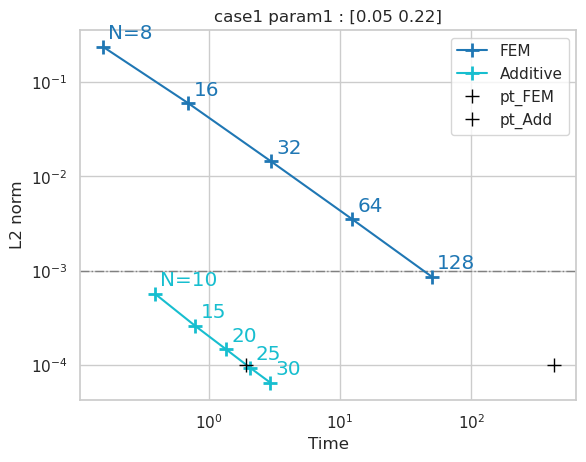

In [24]:
colors = ["tab:blue","tab:red","tab:cyan","tab:orange"]

plt.figure()

def plot_values(times,norms,color,label,tab_nb_vert):
    tab_nb_vert_str = [f"{nb_vert}" for nb_vert in tab_nb_vert]
    tab_nb_vert_str[0] = "N="+tab_nb_vert_str[0]
    plt.loglog(times,norms,"+-",color=color,label=label,markersize=10,markeredgewidth=2)
    for i in range(len(tab_nb_vert)):
        offset_x = 0.1
        offset_y = 0.1
        plt.text(times[i] * (1 + offset_x),norms[i] * (1 + offset_y),tab_nb_vert_str[i],c = color, fontsize="large",ha="left",va="bottom")
plt.axhline(y=1e-3,c="grey",linewidth=1,linestyle="-.")

plot_values(tab_times_FEM,tab_err_FEM,colors[0],"FEM",tab_nb_vert_FEM)
# plot_values(times_phifem,norms_phifem,colors[1],"PHIFEM")

plot_values(tab_times_Corr,tab_err_Corr,colors[2],"Additive",tab_nb_vert_Corr)
# plot_values(times_corr_add_phifem,norms_corr_add_phifem,colors[3],"Corr_add_PHIFEM")


plt.xlabel("Time")
plt.ylabel("L2 norm")

plt.loglog(pt_FEM[0],pt_FEM[1],"+",label="pt_FEM",color="black",markersize=10)
plt.loglog(pt_Add[0],pt_Add[1],"+",label="pt_Add",color="black",markersize=10)

plt.legend()
plt.title(f'case{testcase} param{param_num} : {param}')

In [155]:
# pre = int(np.log10(given_precision))
# result_file = result_dir+f'times_table_param{param_num}_degree{degree}_1e{pre}'

# df_given_precision.to_excel(result_file+'.xlsx')

# df_styled = df_given_precision.style.format("{:.2e}")
# dfi.export(df_styled,result_file+".png",dpi=1000)

In [54]:
# given_precision = 1e-4
# times_inter = get_time(given_precision)
# # Create a dataframe with the times interpolated
# df_given_precision = pd.DataFrame.from_dict(times_inter).T
# # réorganiser lignes et colonnes par clés
# df_given_precision = df_given_precision.reindex(methods)
# df_given_precision = df_given_precision[steps]
# # Create an excel file with the times

# df_given_precision

In [55]:
# pre = int(np.log10(given_precision))
# result_file = result_dir+f'times_table_param{param_num}_degree{degree}_1e{pre}'

# df_given_precision.to_excel(result_file+'.xlsx')

# df_styled = df_given_precision.style.format("{:.2e}")
# dfi.export(df_styled,result_file+".png",dpi=1000)